Goal: Combine processed DWR Periodic GWL database with local continuous groundwater monitoring data. This dataset will be preprocess for the entire period of record and filtered down to recent time when loaded into the model main code.

In [1]:
import os
from os.path import basename, dirname
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime

In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir

'C:\\Users\\ajcalder/Box/research_cosumnes/GWFlowModel'

In [3]:
hob_dir = gwfm_dir+'/HOB_data'
ghb_dir = gwfm_dir+'/GHB_data'

In [4]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')


In [5]:
# set reasonable range of dates that might be used for Cosumnes modeling work
strt_date = pd.to_datetime('1990-10-01')
end_date = pd.to_datetime(datetime.date.today())


## Load and prepare DWR data

In [6]:
# con_stations = pd.read_csv(ghb_dir+'/dwr_continuous_groundwater/gwlstations.csv')
# monthly = pd.read_csv(ghb_dir+'/dwr_continuous_groundwater/continuousgroundwatermonthly.csv')

In [7]:
stations = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/stations.csv')
periodic = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/measurements.csv')
stations_gpd = gpd.GeoDataFrame(stations,
                                geometry = gpd.points_from_xy( stations.LONGITUDE, stations.LATITUDE), crs = 'epsg:4326')
# need to use the domain in lat, long crs as some wells may edge in utm zone 11n
stations_gpd = gpd.sjoin(stations_gpd.to_crs('epsg:32610'),m_domain, how = 'inner', op = 'intersects')
# join the periodic measurements with the site locations 
domain_periodic = periodic.merge(stations_gpd, on = ['SITE_CODE'])

domain_periodic['MSMT_DATE']=pd.to_datetime(domain_periodic['MSMT_DATE'])
domain_periodic = domain_periodic.set_index('MSMT_DATE')
# filter to modern time
domain_periodic = domain_periodic.loc[domain_periodic.index>strt_date]

In [18]:

# domain_periodic_2010s = pd.read_csv(hob_dir+'/dwr_gwe_data_2010s.csv', index_col = 'MSMT_DATE', parse_dates =True)
# filter out columns relevant to observation
domain_periodic_adj = domain_periodic.filter(['SITE_CODE', 'GWE', 'WLM_RPE','WLM_GSE',
                              'WLM_ACC_DESC','LATITUDE','LONGITUDE','WELL_DEPTH', 'WELL_TYPE'],axis=1)

# filter out measurements for the actual modeled period
domain_periodic_adj.index = pd.to_datetime(domain_periodic_adj.index)

dwr_obs = domain_periodic_adj.loc[(domain_periodic.index>strt_date)&(domain_periodic.index<end_date)]
# convert observations to geodataframe to merge with
dwr_obs_gpd = gpd.GeoDataFrame(dwr_obs, geometry = gpd.points_from_xy(dwr_obs.LONGITUDE,dwr_obs.LATITUDE))
dwr_obs_gpd.crs = 'epsg:4326'
dwr_obs_gpd = dwr_obs_gpd.to_crs('epsg:32610')
# the grid is a 1 based system
dwr_obs_grid = gpd.sjoin(dwr_obs_gpd,grid_p)

# convert units from ft to meters
dwr_obs_grid.loc[:,['GWE','WLM_RPE','WLM_GSE', 'WELL_DEPTH']] *= 0.3048
dwr_obs_grid = dwr_obs_grid.dropna(subset=['GWE'])
# set data source for filtering
dwr_obs_grid['agency'] = 'DWR'

## Load and prepare UC Davis continuous data

In [19]:
ucd_meta = pd.read_csv(hob_dir+'/Cosumnes_MW_metadata.csv')
ucd_mon = pd.read_csv(hob_dir+'/ucd_wells_monthly.csv', index_col = 'dt', parse_dates = True)
# filter out measurements for the actual modeled period
ucd_mon = ucd_mon.loc[strt_date:end_date]
# remove timezone component of date format
ucd_mon.index = ucd_mon.index.tz_localize(tz=None)
# melt dataframe by id and date
ucd_mon = ucd_mon.reset_index().melt(id_vars = ['dt'], value_vars=ucd_mon.columns)
ucd_mon = ucd_mon.rename({'variable':'Well_ID','value':'wse_m'},axis=1)

# remove TZ adjustment from dt


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  after removing the cwd from sys.path.


In [20]:
# convert observations to geodataframe to merge with
ucd_meta_gpd = gpd.GeoDataFrame(ucd_meta, geometry = gpd.points_from_xy(ucd_meta.LONGITUDE,ucd_meta.LATITUDE))
ucd_meta_gpd.crs = 'epsg:4326'
ucd_meta_gpd = ucd_meta_gpd.to_crs('epsg:32610')
# the grid is a 1 based system
ucd_meta_grid = gpd.sjoin(ucd_meta_gpd,grid_p)

# estimate GSE from RPE
ucd_meta_grid['WLM_GSE'] = ucd_meta_grid['MPE (meters)']-1
ucd_meta_grid['WELL_DEPTH'] = ucd_meta_grid['Well Depth (ft)']*0.3048

In [21]:
# simplify from 22 to 8 wells for now because there will be overfitting of wells at Oneto-Denier and 
# these wells all have LevelSenders allowing for easier data access
well_vertices = ucd_meta_grid.set_index('Well_ID').loc[['MW_DR1', 'MW_9', 'MW_11', 'MW_19','MW_5', 'MW_22','Rooney1']]

# join wse data with location and metadata
ucd_obs = ucd_mon.join(well_vertices, how = 'right',on = 'Well_ID')
ucd_obs = ucd_obs.dropna(subset=['wse_m']) # remove NA values

# prepare UCD obs for joining with DWR obs
ucd_obs = ucd_obs.set_index('dt').loc[:,['Well_ID','wse_m','WLM_GSE','node','row','column', 'WELL_DEPTH']]
ucd_obs = ucd_obs.rename({'Well_ID':'SITE_CODE','wse_m':'GWE'},axis=1)
# set data source for filtering
ucd_obs['agency'] = 'UCD'

## Join DWR and UCD data
UCD data is commented out for now

In [22]:
# join UCD and DWR obs
all_obs = dwr_obs_grid.loc[:,['SITE_CODE','GWE','WLM_GSE','node','row','column', 'agency', 'WELL_DEPTH']].append(ucd_obs)
# all_obs = dwr_obs_grid.loc[:,['SITE_CODE','GWE','WLM_GSE','node','row','column']]
# make row and column 0 based
all_obs.row -= 1
all_obs.column -=1

## Adjust observations for elevation

In [23]:
# find DEM elevation and difference between measured and DEM
all_obs['dem_elev'] = dem_data[(all_obs.row).values.astype(int),(all_obs.column).values.astype(int)]
all_obs['dem_wlm_gse'] = all_obs.dem_elev - all_obs.WLM_GSE
# recalculate WSE based on DEM elevation
all_obs['wse_m_adj'] = all_obs.dem_elev - (all_obs['WLM_GSE'] - all_obs.GWE)

# get spd corresponding to dates
all_obs['spd'] = (all_obs.index-strt_date).days.values


25.50 % of the sites have a difference > 1 m


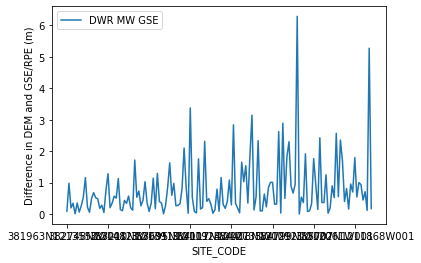

In [24]:
import matplotlib.pyplot as plt
# dwr_obs_grid['dem_wlm_gse'] = dwr_obs_grid.dem_elev - dwr_obs_grid.WLM_GSE
# ucd_meta_grid['dem_elev'] = dem_data[(ucd_meta_grid.row-1).values.astype(int),(ucd_meta_grid.column-1).values.astype(int)]
# ucd_meta_grid['dem_rpe'] = ucd_meta_grid.dem_elev - ucd_meta_grid['MPE (meters)']
# aggregate by site id and then plot to look at difference
temp = all_obs.groupby('SITE_CODE').aggregate( func = 'mean').dem_wlm_gse.abs()
temp.plot(label = 'DWR MW GSE')
# ucd_meta_grid['dem_wlm_gse'].plot(label = 'UCD MW RPE')
plt.legend()
max_diff = 1
plt.ylabel('Difference in DEM and GSE/RPE (m)')
print('%.2f'%(((temp>max_diff).sum()/temp.shape)[0]*100) ,'% of the sites have a difference >', max_diff,'m' )

## Create unique observation names

In [25]:

all_obs['obs_nam'] = all_obs.node.astype(str)
# use the model grid node number to shorten the dwr_site code name
nodes = all_obs.obs_nam.unique()

for i in np.arange(0,len(nodes)):
    # find matching observations to the unique node
    df = all_obs.loc[all_obs.obs_nam==nodes[i]]
    # check ndim for counting number of obs per node
    if df.ndim >1: nobs = len(df)
    else: nobs=1    
    for n in np.arange(0,nobs):
        df.obs_nam.iloc[n] = 'N'+df.obs_nam.iloc[n]+'.'+str(n+1).zfill(5)
#     # reset node name in dwr_obs
    all_obs.loc[all_obs.obs_nam==nodes[i],:] = df.copy()
    

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [26]:
# save cleaned data to box data for all data
all_obs.to_csv(hob_dir+'/all_obs_grid_prepared.csv',index=True)